## Cargar Datos

In [3]:
# Cargar Datos CSV
import pandas as pd
data = pd.read_csv('DatosSingapore2.csv')

## Organizar variables y conjuntos de train y test para el modelo con todos los datos

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 1. Detectar columnas binarias
binary_vars = [col for col in data.columns 
               if set(data[col].dropna().unique()).issubset({0, 1})]

# 2. Detectar columnas numéricas verdaderas
numerical_vars = data.select_dtypes(include=['number']).columns
numerical_true = [col for col in numerical_vars if col not in binary_vars]

# 3. Features
X = data[binary_vars + numerical_true]

# 4. Escalar únicamente numéricas continuas
scaler = StandardScaler()
X_scaled = X.copy()
X_scaled[numerical_true] = scaler.fit_transform(X[numerical_true])

# Eliminar price de x_scaled si está presente
if 'price' in X_scaled.columns:
    X_scaled = X_scaled.drop(columns=['price'])

# 5. Convertir todo a float32
X_scaled = X_scaled.astype("float32")
y = data["price"].astype("float32")

# 6. Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

Epoch 1/200
62/62 - 1s - loss: 76171.9297 - mean_absolute_error: 223.0260 - val_loss: 60150.0430 - val_mean_absolute_error: 191.1765 - 826ms/epoch - 13ms/step
Epoch 2/200
62/62 - 0s - loss: 25026.5977 - mean_absolute_error: 111.9967 - val_loss: 12616.7959 - val_mean_absolute_error: 76.5365 - 128ms/epoch - 2ms/step
Epoch 3/200
62/62 - 0s - loss: 12689.7441 - mean_absolute_error: 76.8430 - val_loss: 11379.7988 - val_mean_absolute_error: 72.5086 - 125ms/epoch - 2ms/step
Epoch 4/200
62/62 - 0s - loss: 11184.3516 - mean_absolute_error: 70.9292 - val_loss: 10762.5498 - val_mean_absolute_error: 69.5194 - 127ms/epoch - 2ms/step
Epoch 5/200
62/62 - 0s - loss: 10811.2998 - mean_absolute_error: 69.8751 - val_loss: 10237.8535 - val_mean_absolute_error: 69.1438 - 126ms/epoch - 2ms/step
Epoch 6/200
62/62 - 0s - loss: 10482.0117 - mean_absolute_error: 69.3914 - val_loss: 9998.1895 - val_mean_absolute_error: 68.7371 - 126ms/epoch - 2ms/step
Epoch 7/200
62/62 - 0s - loss: 10433.2979 - mean_absolute_err

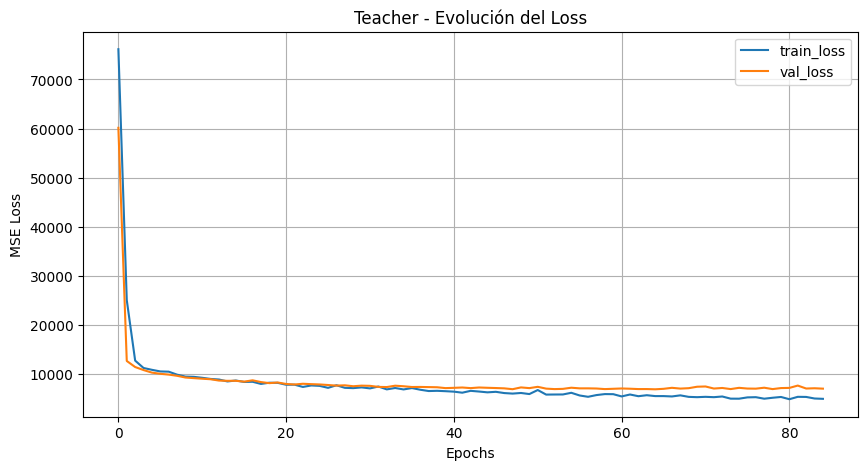

16/16 [==============================] - 0s 1ms/step

=== Resultados del TEACHER ===
MSE:  6840.8101
MAE:  53.9731
RMSE: 82.7092


In [5]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

# =========================================================
# 1. CREAR EL NUEVO TEACHER MODEL
# =========================================================
def create_teacher_model(input_dim):
    model = keras.Sequential()

    # Capa de entrada
    model.add(keras.layers.Input(shape=(input_dim,)))

    # Capas ocultas (nuevo diseño)
    for _ in range(3):
        model.add(keras.layers.Dense(
            64,
            activation="relu",
            kernel_regularizer=keras.regularizers.l2(0.0005)
        ))
        model.add(keras.layers.Dropout(0.2))

    # Capa de salida (lineal)
    model.add(keras.layers.Dense(1, activation="linear"))

    # Compilación
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss="mean_squared_error",
        metrics=["mean_absolute_error"]
    )

    return model

# Crear el teacher
teacher = create_teacher_model(X_train.shape[1])

# Early stopping (igual que modelo original)
early_stop = keras.callbacks.EarlyStopping(
    patience=20,
    restore_best_weights=True
)

# =========================================================
# 2. ENTRENAMIENTO DEL TEACHER
# =========================================================
history_teacher = teacher.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=200,
    batch_size=32,
    verbose=2,
    callbacks=[early_stop]
)

# =========================================================
# 3. GRAFICAR EL LOSS DEL TEACHER
# =========================================================
plt.figure(figsize=(10,5))
plt.plot(history_teacher.history['loss'], label='train_loss')
plt.plot(history_teacher.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.title('Teacher - Evolución del Loss')
plt.legend()
plt.grid(True)
plt.show()

# =========================================================
# 4. PREDICCIONES DEL TEACHER PARA KNOWLEDGE DISTILLATION
# =========================================================
teacher_train_preds = teacher.predict(X_train).astype("float32")
teacher_test_preds  = teacher.predict(X_test).astype("float32")

# =========================================================
# 5. EVALUACIÓN FINAL DEL TEACHER
# =========================================================
mse_teacher, mae_teacher = teacher.evaluate(X_test, y_test, verbose=0)

print("\n=== Resultados del TEACHER ===")
print(f"MSE:  {mse_teacher:.4f}")
print(f"MAE:  {mae_teacher:.4f}")
print(f"RMSE: {(mse_teacher**0.5):.4f}")


In [6]:
from sklearn.feature_selection import mutual_info_regression

mi = mutual_info_regression(X_train, y_train)
mi = pd.Series(mi, index=X_train.columns).sort_values(ascending=False)

top_vars_mi = mi.index[:20]   # variables de mayor aporte informativo
print("Top 20 variables por MI:")
print(top_vars_mi)

Top 20 variables por MI:
Index(['host_total_listings_count', 'calculated_host_listings_count',
       'host_id', 'host_acceptance_rate', 'host_response_rate', 'accommodates',
       'latitude', 'longitude', 'availability_eoy', 'availability_365',
       'number_of_private_bathrooms', 'minimum_nights_avg_ntm',
       'number_of_shared_bathrooms', 'room_type:Private room',
       'room_type:Entire home/apt', 'minimum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'property_type:Private room in rental unit',
       'bathrooms'],
      dtype='object')


In [7]:
import xgboost as xgb

model = xgb.XGBRegressor()
model.fit(X_train, y_train)

importances = pd.Series(model.feature_importances_, index=X_train.columns)
top_vars_xgb = importances.sort_values(ascending=False).head(20).index

#mostrar top variables
print("Top 20 variables por XGBoost:")
print(top_vars_xgb)

Top 20 variables por XGBoost:
Index(['room_type:Entire home/apt', 'maximum_minimum_nights',
       'minimum_minimum_nights', 'accommodates',
       'calculated_host_listings_count', 'bathrooms',
       'property_type:Room in hotel', 'minimum_nights', 'bedrooms',
       'property_type:Room in boutique hotel', 'maximum_maximum_nights',
       'property_type:Shared room in bed and breakfast',
       'maximum_nights_avg_ntm', 'minimum_maximum_nights',
       'neighbourhood_cleansed:Orchard', 'number_of_shared_bathrooms', 'beds',
       'neighbourhood_cleansed:Marina South', 'host_response_rate',
       'neighbourhood_cleansed:Changi'],
      dtype='object')


In [9]:
candidate_vars = set(top_vars_mi).intersection(set(top_vars_xgb)).intersection(set(top_vars_perm))
print("Variables candidatas seleccionadas:")
print(candidate_vars)

Variables candidatas seleccionadas:
{'minimum_minimum_nights', 'bathrooms', 'accommodates', 'maximum_minimum_nights', 'calculated_host_listings_count'}


In [10]:
# =========================================================
# Preparación final para el STUDENT usando candidate_vars
# =========================================================

# candidate_vars debe existir (resultado de la intersección)
student_vars = [v for v in candidate_vars]  # lista a partir del set

# Asegurarnos de que las columnas existan en X_scaled (o en X_train.columns)
existing_vars = [v for v in student_vars if v in X_train.columns]
missing = [v for v in student_vars if v not in X_train.columns]
if missing:
    print("Advertencia: las siguientes variables no están en X_train/X_scaled y serán ignoradas:")
    print(missing)

student_vars = existing_vars
print("\nVariables finales que usará el STUDENT:")
print(student_vars)

# =========================================================
# Construir X_train_student / X_test_student a partir de X_train/X_test
# (X_train y X_test ya vienen de X_scaled, por lo que ya están escalados)
# =========================================================
X_train_student = X_train[student_vars].copy()
X_test_student  = X_test[student_vars].copy()

# Forzar tipo float32 (por si acaso)
X_train_student = X_train_student.astype("float32")
X_test_student  = X_test_student.astype("float32")

# =========================================================
# Targets reales (asegurar forma) y distillation targets
# =========================================================
# Aseguramos que y_train/y_test estén alineados con X_train/X_test (ya lo están por split original)
y_train_real = y_train.values.reshape(-1, 1).astype("float32")
y_test_real  = y_test.values.reshape(-1, 1).astype("float32")

# alpha ya definido antes; si no, definirlo (ej: 0.4)
try:
    alpha
except NameError:
    alpha = 0.4
    print("alpha no estaba definido. Usando alpha = 0.4")

# teacher_train_preds y teacher_test_preds deben existir y tener la misma orden/shape que X_train / X_test
# Aseguramos shapes
teacher_train_preds = teacher_train_preds.reshape(-1, 1) if teacher_train_preds.ndim == 1 else teacher_train_preds
teacher_test_preds  = teacher_test_preds.reshape(-1, 1)  if teacher_test_preds.ndim == 1 else teacher_test_preds

# Convertir a float32
teacher_train_preds = teacher_train_preds.astype("float32")
teacher_test_preds  = teacher_test_preds.astype("float32")

# Mezcla para distillation
y_train_distill = alpha * teacher_train_preds + (1 - alpha) * y_train_real
y_test_distill  = alpha * teacher_test_preds  + (1 - alpha) * y_test_real

# =========================================================
# Resumen de shapes y sanity checks
# =========================================================
print("\nShapes finales:")
print("X_train_student:", X_train_student.shape)
print("y_train_real:", y_train_real.shape)
print("teacher_train_preds:", teacher_train_preds.shape)
print("y_train_distill:", y_train_distill.shape)
print("X_test_student:", X_test_student.shape)
print("y_test_real:", y_test_real.shape)
print("teacher_test_preds:", teacher_test_preds.shape)
print("y_test_distill:", y_test_distill.shape)




Variables finales que usará el STUDENT:
['minimum_minimum_nights', 'bathrooms', 'accommodates', 'maximum_minimum_nights', 'calculated_host_listings_count']
alpha no estaba definido. Usando alpha = 0.4

Shapes finales:
X_train_student: (1967, 5)
y_train_real: (1967, 1)
teacher_train_preds: (1967, 1)
y_train_distill: (1967, 1)
X_test_student: (492, 5)
y_test_real: (492, 1)
teacher_test_preds: (492, 1)
y_test_distill: (492, 1)


In [1]:
# =========================================================
# 1) SELECCIÓN AUTOMÁTICA DE VARIABLES (NUMÉRICAS + CATEGÓRICAS)
# =========================================================
# Correlación numéricas con price
corr_num = data.corr(numeric_only=True)['price'].abs().sort_values(ascending=False)
top_num_vars = [v for v in corr_num.index if v != 'price'][:20]

# Inicializamos lista con numéricas
X_parts = [data[top_num_vars].copy()]

# Categóricas importantes
cat_cols = [col for col in ["room_type", "property_type", "host_response_time"] if col in data.columns]

if cat_cols:  # Solo si hay categóricas
    X_cat_full = pd.get_dummies(data[cat_cols].astype(str), prefix=cat_cols)
    
    if not X_cat_full.empty:  # Verificamos que no esté vacío
        # Correlación categóricas con price
        corr_cat = X_cat_full.apply(lambda col: col.corr(data['price'])).abs().sort_values(ascending=False)
        top_cat_vars = corr_cat.index[:10]  # Top 10 dummies más correlacionadas
        X_parts.append(X_cat_full[top_cat_vars])

# Concatenar solo si hay partes
if X_parts:
    X_student = pd.concat(X_parts, axis=1).fillna(0)
else:
    raise ValueError("No hay variables numéricas ni categóricas para crear el dataset.")

# =========================================================
# 2) ESCALADO Y ALINEACIÓN
# =========================================================
X_train_student = X_student.loc[X_train.index].copy()
X_test_student  = X_student.loc[X_test.index].copy()

scaler_student = StandardScaler()
X_train_student[top_num_vars] = scaler_student.fit_transform(X_train_student[top_num_vars])
X_test_student[top_num_vars]  = scaler_student.transform(X_test_student[top_num_vars])

# Convertir a float32
X_train_student = X_train_student.astype("float32")
X_test_student  = X_test_student.astype("float32")

# Targets
y_train_student = y_train.astype("float32")
y_test_student  = y_test.astype("float32")


alpha = 0.4

# Aseguramos la forma (N,1)
y_train_real = y_train.values.reshape(-1, 1).astype("float32")
y_test_real  = y_test.values.reshape(-1, 1).astype("float32")

# Mezcla para distillation
y_train_distill = alpha * teacher_train_preds + (1 - alpha) * y_train_real
y_test_distill  = alpha * teacher_test_preds  + (1 - alpha) * y_test_real



NameError: name 'data' is not defined

Epoch 1/200
62/62 - 1s - loss: 72289.0781 - mean_absolute_error: 221.9046 - val_loss: 59448.4062 - val_mean_absolute_error: 198.5972 - 684ms/epoch - 11ms/step
Epoch 2/200
62/62 - 0s - loss: 32915.5508 - mean_absolute_error: 132.4681 - val_loss: 12092.3174 - val_mean_absolute_error: 83.2409 - 144ms/epoch - 2ms/step
Epoch 3/200
62/62 - 0s - loss: 11859.4307 - mean_absolute_error: 78.2658 - val_loss: 11031.7705 - val_mean_absolute_error: 75.7078 - 198ms/epoch - 3ms/step
Epoch 4/200
62/62 - 0s - loss: 10999.6777 - mean_absolute_error: 74.7866 - val_loss: 10428.1387 - val_mean_absolute_error: 72.2067 - 102ms/epoch - 2ms/step
Epoch 5/200
62/62 - 0s - loss: 10675.2041 - mean_absolute_error: 72.7975 - val_loss: 10278.2852 - val_mean_absolute_error: 72.4530 - 144ms/epoch - 2ms/step
Epoch 6/200
62/62 - 0s - loss: 10309.3516 - mean_absolute_error: 71.9992 - val_loss: 9912.8008 - val_mean_absolute_error: 70.6925 - 112ms/epoch - 2ms/step
Epoch 7/200
62/62 - 0s - loss: 10083.9277 - mean_absolute_err

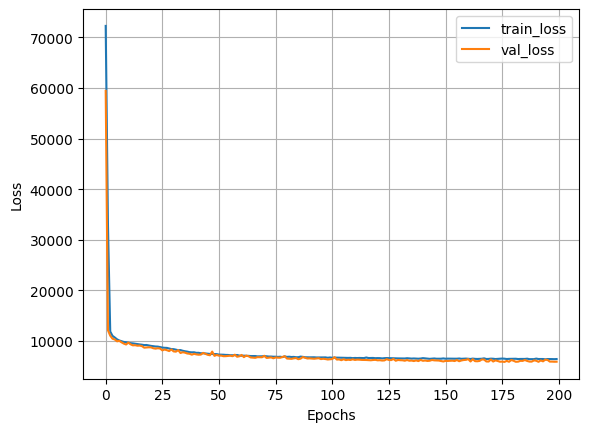

16/16 [==============================] - 0s 485us/step

Resultados Student:
RMSE: 97.19
MSE : 9445.90
MAPE: 36.71%


In [12]:
from sklearn.metrics import mean_absolute_percentage_error


# =========================================================
# 1) CREAR MODELO STUDENT (RECOMENDADO)
# =========================================================
def create_student_model(input_dim):

    model = keras.Sequential([
        keras.layers.Input(shape=(input_dim,)),

        keras.layers.Dense(128, activation="relu"),
        keras.layers.Dense(64, activation="relu"),
        keras.layers.Dense(32, activation="relu"),

        keras.layers.Dense(1, activation="linear")
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss="mean_squared_error",
        metrics=["mean_absolute_error"]
    )
    return model



student = create_student_model(X_train_student.shape[1])

# =========================================================
# 2) ENTRENAMIENTO CON DISTILLATION TARGETS
# =========================================================

history_student = student.fit(
    X_train_student, y_train_distill,
    validation_data=(X_test_student, y_test_distill),
    epochs=200,
    batch_size=32,
    verbose=2,
    callbacks=[keras.callbacks.EarlyStopping(patience=25, restore_best_weights=True)]
)

# =========================================================
# 3) GRÁFICA DE LOSS
# =========================================================
plt.plot(history_student.history['loss'], label='train_loss')
plt.plot(history_student.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# =========================================================
# 4) EVALUACIÓN vs Y REAL
# =========================================================
y_pred = student.predict(X_test_student)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mse = mean_squared_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

print("\nResultados Student:")
print(f"RMSE: {rmse:.2f}")
print(f"MSE : {mse:.2f}")
print(f"MAPE: {mape:.2%}")
